In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step1: 读取数据

In [2]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
data = pd.read_csv('whole_car_9.csv')

## 输出数据的大小信息
print('shape:',data.shape)

shape: (103585, 160)


### 1) 数据简要浏览

In [3]:
## 通过.head() 简要浏览读取数据的形式
data.head()

,Unnamed: 0,Brand,Series,CarName,Province,City,Miles,Date,二手车报价,新车厂商指导价,...,MarketTime_std,MaxPower_std,MaxTorque_std,Displacement_std,size_l_std,size_w_std,size_h_std,Doors_std,Seats_std,Oil_std
0,0,奥迪,奥迪Q5,奥迪Q5 2017款 Plus 40 TFSI 技术型,四川,成都,7.55,18-Feb,26.58,42.76万,...,-0.471691,0.156421,0.353657,-0.227530,-0.334766,0.609859,0.563339,0.826215,-0.104530,0.357155
1,1,奥迪,奥迪A4L,奥迪A4L 2015款 35 TFSI 自动标准型,浙江,温州,10.00,14-Oct,13.50,31.28万,...,0.517681,-0.391128,0.110327,-0.227530,0.056504,-0.359804,-0.824623,-0.488452,-0.104530,NaN
2,2,宝马,宝马8系,宝马8系 2019款 840i 双门轿跑车 M运动套装,河北,石家庄,0.70,19-Dec,83.50,109.80万,...,-1.166926,1.355108,1.570305,1.041552,0.341065,0.663729,-1.345109,-3.117786,-1.269811,-0.045872
3,3,宝马,宝马5系,宝马5系 2014款 525Li 豪华设计套装,四川,成都,10.00,14-Sep,24.28,49.96万,...,0.758340,0.023233,0.029217,-0.227530,0.927971,0.098093,-0.490484,-0.488452,-0.104530,NaN
4,4,奥迪,奥迪A8,奥迪A8 2013款 A8L 45 TFSI quattro舒适型,山东,青岛,7.30,14-May,31.80,93.10万,...,1.079217,0.807560,0.921426,1.041552,1.556375,1.296704,-0.689682,-0.488452,-0.104530,1.062452


### 2) 数据信息查看

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103585 entries, 0 to 103584
Columns: 160 entries, Unnamed: 0 to Oil_std
dtypes: float64(132), int64(9), object(19)
memory usage: 126.4+ MB


### 3)数据统计信息浏览

In [54]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
data.describe()

,Unnamed: 0,Miles,二手车报价,上市时间,Brand_label,Series_label,CarName_label,Province_label,citycode_0,citycode_1,...,Doors_std,Seats_std,Oil_std,series_amount,series_price_max,series_price_median,series_price_min,series_price_sum,series_price_std,series_price_average
count,103585.000000,103585.000000,103585.000000,103585.000000,103585.000000,103585.000000,103585.000000,103585.000000,103585.000000,103585.000000,...,1.035850e+05,1.035850e+05,9.095100e+04,103585.000000,103585.000000,103585.000000,103585.000000,103585.000000,103433.000000,103585.000000
mean,51792.000000,6.499733,29.964123,2015.606303,62.763547,575.085707,6392.923995,13.761896,0.048627,0.040923,...,2.311211e-15,8.793160e-15,-2.571673e-16,0.223903,0.017899,0.008628,0.004079,0.221685,0.061792,0.011839
std,29902.558154,4.079936,48.782001,3.115996,30.398523,327.676034,3910.064232,7.619490,0.215087,0.198113,...,1.000005e+00,1.000005e+00,1.000005e+00,0.259644,0.027752,0.013417,0.010210,0.276987,0.096581,0.017495
min,0.000000,0.010000,0.480000,2006.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.117786e+00,-3.600371e+00,-3.521980e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25896.000000,3.300000,9.800000,2013.090000,54.000000,384.000000,3570.000000,9.000000,0.000000,0.000000,...,-4.884518e-01,-1.045304e-01,-6.504129e-01,0.043074,0.005135,0.002992,0.001234,0.023007,0.015393,0.004066
50%,51792.000000,6.000000,17.980000,2016.060000,58.000000,535.000000,5973.000000,14.000000,0.000000,0.000000,...,-4.884518e-01,-1.045304e-01,-1.970075e-01,0.129532,0.010241,0.005831,0.001811,0.074101,0.032662,0.007566
75%,77688.000000,9.000000,32.800000,2018.080000,79.000000,795.000000,9361.000000,18.000000,0.000000,0.000000,...,8.262153e-01,-1.045304e-01,5.082897e-01,0.291292,0.017645,0.009174,0.004089,0.397658,0.067454,0.013042
max,103584.000000,46.800000,3350.000000,2022.010000,134.000000,1258.000000,14094.000000,28.000000,1.000000,1.000000,...,2.140882e+00,6.887151e+00,6.201046e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step2: 特征与标签构建

In [6]:
# 计算某系列Series的统计量

groupby = data.groupby("Series_label")
all_info = {}
for kind, kind_data in groupby:
    info = {}
    kind_data = kind_data[kind_data['二手车报价'] > 0]
    kind_data.rename(columns={'二手车报价': 'price'}, inplace=True)
    info['series_amount'] = len(kind_data)
    info['series_price_max'] = kind_data.price.max()
    info['series_price_median'] = kind_data.price.median()
    info['series_price_min'] = kind_data.price.min()
    info['series_price_sum'] = kind_data.price.sum()
    info['series_price_std'] = kind_data.price.std()
    info['series_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "Series_label"})
data = data.merge(brand_fe, how='left', on='Series_label')

In [7]:
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['series_amount'] = ((data['series_amount'] - np.min(data['series_amount'])) / 
                        (np.max(data['series_amount']) - np.min(data['series_amount'])))
data['series_price_average'] = ((data['series_price_average'] - np.min(data['series_price_average'])) / 
                               (np.max(data['series_price_average']) - np.min(data['series_price_average'])))
data['series_price_max'] = ((data['series_price_max'] - np.min(data['series_price_max'])) / 
                           (np.max(data['series_price_max']) - np.min(data['series_price_max'])))
data['series_price_median'] = ((data['series_price_median'] - np.min(data['series_price_median'])) /
                              (np.max(data['series_price_median']) - np.min(data['series_price_median'])))
data['series_price_min'] = ((data['series_price_min'] - np.min(data['series_price_min'])) / 
                           (np.max(data['series_price_min']) - np.min(data['series_price_min'])))
data['series_price_std'] = ((data['series_price_std'] - np.min(data['series_price_std'])) / 
                           (np.max(data['series_price_std']) - np.min(data['series_price_std'])))
data['series_price_sum'] = ((data['series_price_sum'] - np.min(data['series_price_sum'])) / 
                           (np.max(data['series_price_sum']) - np.min(data['series_price_sum'])))

In [19]:
X_data = data[[
              'Series_label',  # 车系标签
              'Miles_std',  # 行驶里程
              'CarAge_std',  # 车龄（月）
              'Price_NewCar_std',  # 新车价格
              'MarketTime_std',  # 上市时间（月）
              'MaxPower_std',  # 最大功率
              'MaxTorque_std',  # 最大扭矩
              'Displacement_std',  # 排量
              'size_l_std',  # 车辆尺寸-长
              'size_w_std',  # 车辆尺寸-宽
              'size_h_std',  # 车辆尺寸-高
              'Doors_std',  # 车门数量
              'Seats_std',  # 座位数量
              'Oil_std',  # 耗油量
              'DepriciationRate',  # 贬值率
              'citycode_0',  # 城市编码
              'citycode_1',
              'citycode_2',
              'citycode_3',
              'citycode_4',
              'citycode_5',
              'citycode_6',
              'citycode_7',
              'citycode_8',
              'citycode_9',
              'citycode_10',
              'citycode_11',
              'citycode_12',
              'citycode_13',
              'citycode_14',
              'citycode_15',
              'citycode_16',
              'citycode_17',
              'citycode_18',
              'citycode_19',
              'citycode_20',
              'citycode_21',
              'citycode_22',
              'citycode_23',
              'citycode_24',
              'citycode_25',
              'citycode_26',
              'citycode_27',
              'citycode_28',
              'levelcode_0',  # 车辆级别编码-例如“紧凑型SUV”
              'levelcode_1',
              'levelcode_2',
              'levelcode_3',
              'levelcode_4',
              'levelcode_5',
              'levelcode_6',
              'levelcode_7',
              'levelcode_8',
              'levelcode_9',
              'levelcode_10',
              'levelcode_11',
              'levelcode_12',
              'levelcode_13',
              'levelcode_14',
              'levelcode_15',
              'levelcode_16',
              'isEV',  # 能源类型编码
              'isICE',
              'pollutioncode_0',  # 污染等级编码
              'pollutioncode_1',
              'pollutioncode_2',
              'pollutioncode_3',
              "isTurbo",  # 涡轮增压编码
              "notTurbo",
              "TurboNotApplicable",
              'transmissioncode_0',  # 变速箱类型编码
              'transmissioncode_1',
              'transmissioncode_2',
              'transmissioncode_3',
              'transmissioncode_4',
              'transmissioncode_5',
              'transmissioncode_6',
              'transmissioncode_7',
              'transmissioncode_8',
              'transmissioncode_9',
              'transmissioncode_10',
              'transmissioncode_11',
              'transmissioncode_12',
              'transmissioncode_13',
              'transmissioncode_14',
              'transmissioncode_15',
              'transmissioncode_16',
              'transmissioncode_17',
              'transmissioncode_18',
              'transmissioncode_19',
              'transmissioncode_20',
              'transmissioncode_21',
              'transmissioncode_22',
              'transmissioncode_23',
              'transmissioncode_24',
              'transmissioncode_25',
              'transmissioncode_26',
              'transmissioncode_27',
              'transmissioncode_28',
              'transmissioncode_29',
              'transmissioncode_30',
              'transmissioncode_31',
              'transmissioncode_32',
              'transmissioncode_33',
              'transmissioncode_34',
              'transmissioncode_35',
              'transmissioncode_36',
              'series_amount', 'series_price_average', 'series_price_max', 'series_price_median', 'series_price_min', 'series_price_std', 'series_price_sum'
              ]]

In [20]:
# X_data = data[['Brand_label', 'Series_label', 'CarName_label', 'Province_label', 'City_label', 'Miles_std', 'CarAge_std', 'Price_NewCar_std', 'Level_label', 
#                'isEV', 'isICE', 'PollutionType', 'MarketTime', 'MaxPower', 'MaxTorque', 'Displacement', 'size_l', 'size_w', 'size_h', 'Doors', 'Seats', 'Oil', 
#               'series_amount', 'series_price_average', 'series_price_max', 'series_price_median', 'series_price_min', 'series_price_std', 'series_price_sum']]
# print(X_data)
# X_data = data[temp_column]
Y_data = data[['二手车报价']]


X_data = X_data.fillna(-1)

## Split data with test
x_train,x_test,y_train,y_test = train_test_split(X_data,Y_data,test_size=0.2)

In [21]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(82868, 114)
(20717, 114)
(82868, 1)
(20717, 1)


## Step3: 模型训练

In [30]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'
param_grid = {
    'learning_rate': [0.01, 0.05,0.1, 0.2],
    'max_depth': [3,5,7,10,15,20,40,55],
}
xgr = GridSearchCV(xgr, param_grid)
xgr.fit(x_train,y_train)
pred_train_xgb=xgr.predict(x_train)
pred_xgb=xgr.predict(x_test)

score_train = mean_absolute_error(y_train,pred_train_xgb)
score = mean_absolute_error(y_test,pred_xgb)

print('Train mae:',score_train)
print('Test mae',score)

Train mae: 1.330496406806975
Test mae 1.4135390765234563


In [34]:
xgr_1 = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

xgr_1.fit(x_train,y_train)
pred_train_xgb_1=xgr_1.predict(x_train)
pred_xgb_1=xgr_1.predict(x_test)

score_train = mean_absolute_error(y_train,pred_train_xgb_1)
score = mean_absolute_error(y_test,pred_xgb_1)

print('Train mae:',score_train)
print('Test mae',score)

Train mae: 0.47722953670088275
Test mae 0.6335691838765481


In [53]:
xgr.best_params_

{'learning_rate': 0.2, 'max_depth': 3}

In [32]:
# light-gbm Model
estimator = lgb.LGBMRegressor(n_estimators = 200)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves':[15,31,63,128], 
}
gbm = GridSearchCV(estimator, param_grid)
gbm.fit(x_train, y_train)
pred_train_gbm=gbm.predict(x_train)
pred_gbm=gbm.predict(x_test)

score_train = mean_absolute_error(y_train,pred_train_gbm)
score = mean_absolute_error(y_test,pred_gbm)

print('Train mae:',score_train)
print('Test mae',score)

Train mae: 0.690751495331581
Test mae 0.8423818724321701


In [46]:
# light-gbm Model
gbm_1 = lgb.LGBMRegressor(num_leaves = 63, n_estimators = 200, learning_rate = 0.1)

gbm_1.fit(x_train, y_train)
pred_train_gbm_1=gbm_1.predict(x_train)
pred_gbm_1=gbm_1.predict(x_test)

score_train = mean_absolute_error(y_train,pred_train_gbm_1)
score = mean_absolute_error(y_test,pred_gbm_1)

print('Train mae:',score_train)
print('Test mae',score)

Train mae: 0.5704405615123789
Test mae 0.69746551680735


In [36]:
gbm.best_params_

{'learning_rate': 0.2, 'num_leaves': 31}

<AxesSubplot:title={'center':'Correlation of Numeric Features with Price'}>

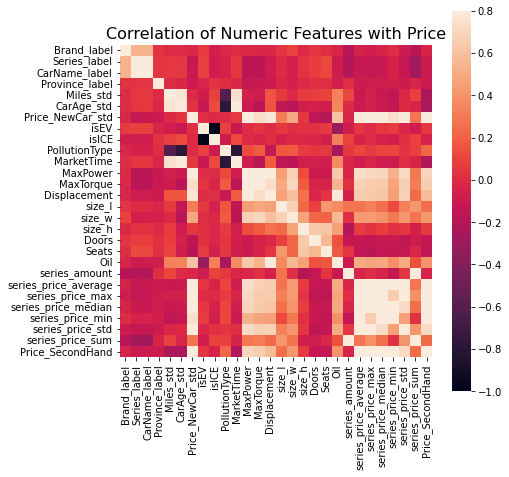

In [52]:
columns_1 = ['Brand_label', 'Series_label', 'CarName_label', 'Province_label', 'Miles_std', 'CarAge_std', 'Price_NewCar_std', 
               'isEV', 'isICE', 'PollutionType', 'MarketTime', 'MaxPower', 'MaxTorque', 'Displacement', 'size_l', 'size_w', 'size_h', 'Doors', 'Seats', 'Oil',
          'series_amount', 'series_price_average', 'series_price_max', 'series_price_median', 'series_price_min', 'series_price_std', 'series_price_sum','Price_SecondHand']
data_numeric = data[columns_1]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

## 模型调参

In [109]:
# from hyperopt import hp, fmin, tpe
# import numpy as np
# import pandas as pd
# import lightgbm as lgb
# from sklearn.model_selection import KFold
# from hyperopt import hp, fmin, tpe
# from numpy.random import RandomState
# from sklearn.metrics import mean_squared_error

### 五折交叉验证

In [118]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_absolute_error,  make_scorer

In [124]:
# model = gbm
# scores = cross_val_score(model, X=x_test, y=y_test, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
# print('AVG:', np.mean(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AVG: 2.251308227763597


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


## 模型集成

In [37]:
from sklearn import linear_model

def Stacking_method(train_reg1,train_reg2, y_train_true,test_pre1,test_pre2, model_L2= linear_model.LinearRegression()):
    model_L2.fit(pd.concat([pd.Series(train_reg1),pd.Series(train_reg2)],axis=1).values,y_train_true)
    Stacking_result = model_L2.predict(pd.concat([pd.Series(test_pre1),pd.Series(test_pre2)],axis=1).values)
    return Stacking_result

In [55]:
model_L2= linear_model.LinearRegression()
Stacking_pre = Stacking_method(pred_train_xgb_1, pred_train_gbm_1, y_train,
                               pred_xgb_1, pred_gbm_1, model_L2)
print('Stacking Test MAE:', mean_absolute_error(y_test, Stacking_pre))

Stacking Test MAE: 0.6316732927046153


In [49]:
X_data.shape

(103585, 114)